In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

In [56]:
def linear(p,x):
    return p[0]*x + p[1]

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

In [57]:
# The code below defines our data fitting function.
# Inputs are:
# initial guess for parameters p0
# the function we're fitting to
# the x,y, and dy variables
# tmi can be set to 1 or 2 if more intermediate data is needed

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:", error)
        return p0, np.zeros_like(p0), np.nan, np.nan
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), np.nan, np.nan
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

## Data

In [58]:
data = pd.read_csv('./data/calibration_3.csv')
data

,centroid,centroid_err,gain,fine_gain,energy,energy_err
0,877.98,0.06,2,1,662.00,1
1,44.29,0.03,2,1,32.00,1
2,682.08,0.11,2,1,511.00,1
3,81.67,0.01,2,1,59.54,1
4,40.34,0.02,2,1,31.00,1
5,110.85,0.05,2,1,81.00,1
6,468.44,0.16,2,1,356.00,1
7,163.72,0.22,2,1,122.00,1


In [59]:
channel = data['centroid'] / (data['gain'] * data['fine_gain'])
channel_err = data['centroid_err'] / (data['gain'] * data['fine_gain'])
data['channel'] = channel
data['channel_err'] = channel_err

In [60]:
data[['energy', 'centroid', 'centroid_err', 'gain', 'channel', 'channel_err']].to_latex(float_format="%.2f", index=False)

'\\begin{tabular}{rrrrrr}\n\\toprule\nenergy & centroid & centroid_err & gain & channel & channel_err \\\\\n\\midrule\n662.00 & 877.98 & 0.06 & 2 & 438.99 & 0.03 \\\\\n32.00 & 44.29 & 0.03 & 2 & 22.14 & 0.01 \\\\\n511.00 & 682.08 & 0.11 & 2 & 341.04 & 0.06 \\\\\n59.54 & 81.67 & 0.01 & 2 & 40.84 & 0.01 \\\\\n31.00 & 40.34 & 0.02 & 2 & 20.17 & 0.01 \\\\\n81.00 & 110.85 & 0.05 & 2 & 55.42 & 0.03 \\\\\n356.00 & 468.44 & 0.16 & 2 & 234.22 & 0.08 \\\\\n122.00 & 163.72 & 0.22 & 2 & 81.86 & 0.11 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Fit

In [61]:
model = linear

params_i = [1, 0]
params_f, params_err, chisq, dof = data_fit(
    params_i, 
    model, 
    channel, data['energy'], data['energy_err']
)
print(params_f)
print(params_err)


Converged with chi-squared 26.53
Number of degrees of freedom, dof = 6.00
Reduced chi-squared 4.42

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.000e+00                | 1.510e+00                | 2.321e-03               
1           | 0.000e+00                | -1.176e+00               | 5.033e-01               
[ 1.50965791 -1.17649778]
[0.00232081 0.50328454]


## Plot

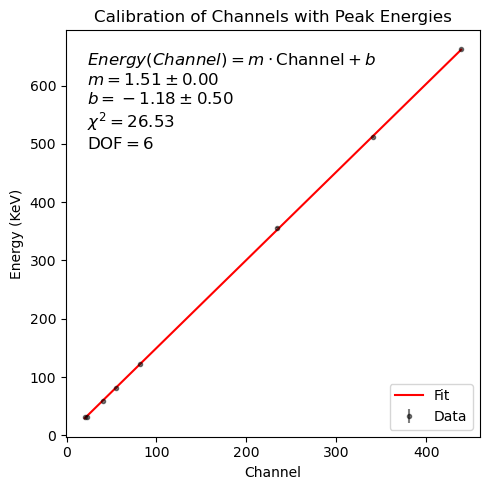

In [62]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.errorbar(
    x=channel, 
    y=data['energy'], yerr=data['energy_err'], 
    fmt='k.', alpha=0.5, label='Data'       
)

linspace = np.linspace(channel.min(), channel.max(), 100)
ax.plot(linspace, model(params_f, linspace), color='r', label='Fit')

txt = '$Energy(Channel) = m \\cdot \\text{Channel}+b$ \n'
txt += '$m = {:.2f} \\pm {:.2f}$ \n'.format(params_f[0], params_err[0])
txt += '$b = {:.2f} \\pm {:.2f}$ \n'.format(params_f[1], params_err[1])
txt += '$\\chi^2 = {:.2f}$ \n'.format(chisq)
txt += 'DOF$ = {}$'.format(dof)
ax.text(0.05, 0.95, txt, transform=ax.transAxes , fontsize=12, verticalalignment='top')

ax.set_xlabel('Channel')
ax.set_ylabel('Energy (KeV)')
ax.set_title('Calibration of Channels with Peak Energies')
ax.legend(loc='lower right')

plt.tight_layout()

In [8]:
#fig.savefig('./figures/calibration_3.pdf')